In [1]:
#Puppies and Kitten Classification Using Images 

<span style='font-family:Lato'><span style='font-size:110%'>
This is an end-to-end Data Science Project which focuses on web scraping the image data to be then used in the modeling.

In [2]:
#--Importing the required libraries

#--For creating image dataset
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import urllib


#--For modeling
import tensorflow as tf
from IPython.display import HTML 
from tensorflow.keras import models,layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = 'whitegrid', context = 'paper', font_scale = 0.9, font = 'Georgia')

In [3]:
url = "https://www.google.com/search?q={s}&tbm=isch&tbs=sur%3Afc&hl=en&ved=0CAIQpwVqFwoTCKCa1c6s4-oCFQAAAAAdAAAAABAC&biw=1251&bih=568"
r = requests.get(url)
print(r.status_code)

200


In [4]:
#--Creating the imge dataset
def get_images(query,path = 'C:/Users/Subhash Ranga/Python Work/Data Science Projects/Image Data/',r = 10):
    while True:
        s = Service('E:/Downloads/chromedriver.exe')
        driver = webdriver.Chrome(service = s)
        driver.get(url.format(s=query))
        height = driver.execute_script('return document.body.scrollHeight')
        print(height)
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight)')
        time.sleep(5)

        imgResults = driver.find_elements(By.XPATH,"//img[contains(@class,'Q4LuWd')]")

        src = []
        for img in imgResults:
            src.append(img.get_attribute('src'))
        for i in range(r):    
            urllib.request.urlretrieve(str(src[i]),path+"{}/{}{}.jpg".format(query,query,i))
        new_height = driver.execute_script('return document.body.scrollHeight')
        if height == new_height:
            break

In [5]:
#--Got the data so commented them 
#get_images('puppies', r = 50)
#get_images('kittens', r = 50)

In [6]:
#--Converting into tf dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Animals', #--Had to change the directory because it also included the ipynb_checkpoints folder as well
                #--I just copied the required folders
    shuffle = True,
    batch_size = 16,
    image_size = (256,256))

Found 90 files belonging to 2 classes.


In [7]:
len(dataset)*16

96

In [8]:
#--Getting the class labels
labels = dataset.class_names
print(f"Number of classes are : {labels}")

Number of classes are : ['kittens', 'puppies']


In [9]:
#dir(dataset)

<span style='font-family:Lato'><span style='font-size:110%'>
I had to delete an image from the puppies folder because it wasn't supported and then there was no InvalidArgumentError

In [10]:
for image_batch, label_batch in dataset.take(1): #--this dataset.take(1) only takes one batch 
    print(image_batch.shape)
    print(label_batch.numpy())    

(16, 256, 256, 3)
[1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1]


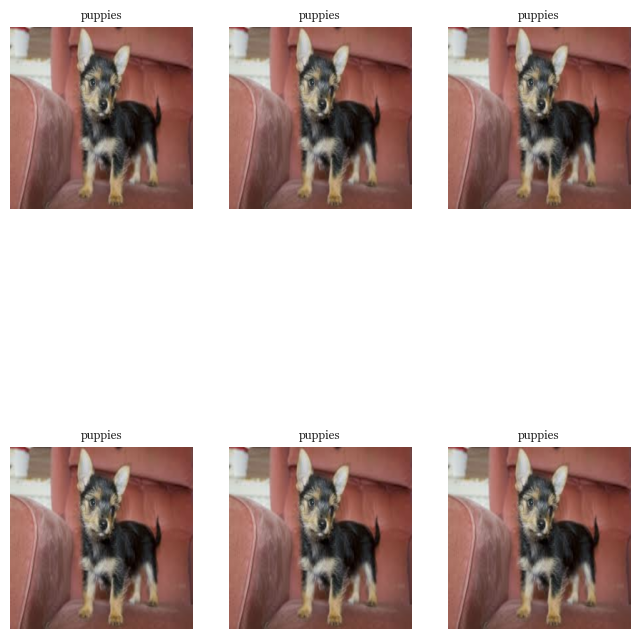

In [11]:
#--Getting a vizsual idea of data
plt.figure(figsize = (8,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(labels[label_batch[0]])
        plt.axis('off')

In [12]:
#--UDF for splitting the dataset
def get_partition_df(df, train_size = 0.8 , test_size = 0.1, valid_size = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed = 12)
    val_1 = round(len(df)*train_size)
    val_2 = round(len(df)*test_size)
    train_data = df.take(val_1)
    test_data = df.skip(val_1)
    valid_data = test_data.take(val_2)
    test_data = test_data.skip(val_2)
    return train_data,test_data,valid_data
train_data,test_data,valid_data = get_partition_df(dataset)

In [13]:
#--Cache and Prefetch
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
#--Image Augumentation
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)    
])

In [15]:
#--Resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/256)
    
])

In [16]:
#--Modeling
n_classes = 3
input_shape = (32, 256,256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax')
])

model.build(input_shape = input_shape)

In [17]:
#--Compling the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [18]:
#--Validating
history = model.fit(
    train_data,
    epochs = 20, #--Small dataset so running time fast
    batch_size = 32,
    verbose = 1,
    validation_data = valid_data
)

Epoch 1/20
5/5 [==============================] - 25s 2s/step - loss: 0.8822 - accuracy: 0.6081 - val_loss: 0.6790 - val_accuracy: 0.4375
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 0.7002 - accuracy: 0.5946 - val_loss: 0.6274 - val_accuracy: 0.6875
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 0.6781 - accuracy: 0.6216 - val_loss: 0.6626 - val_accuracy: 0.4375
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.6628 - accuracy: 0.6081 - val_loss: 0.8644 - val_accuracy: 0.4375
Epoch 5/20
5/5 [==============================] - 7s 2s/step - loss: 0.6756 - accuracy: 0.6081 - val_loss: 0.7087 - val_accuracy: 0.4375
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 0.6530 - accuracy: 0.6081 - val_loss: 0.6905 - val_accuracy: 0.4375
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.6254 - accuracy: 0.6081 - val_loss: 0.7302 - val_accuracy: 0.4375
Epoch 8/20
5/5 [========================

In [19]:
#scores = model.evaluate(test_data)
#print(f"Final Loss : {scores[0]}  \n Final Accuracy : {scores[1]}")

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

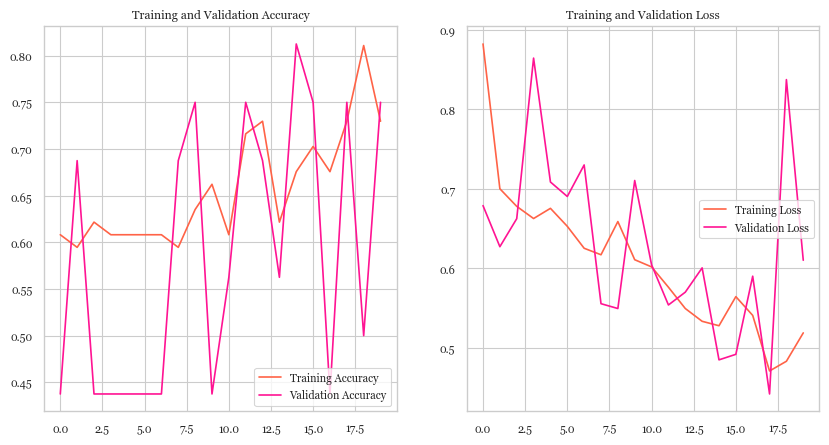

In [22]:
#--Plotting the accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(20),accuracy, label = 'Training Accuracy', color = 'tomato')
plt.plot(range(20), val_accuracy, label = 'Validation Accuracy', color = 'deeppink')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20),loss, label = 'Training Loss', color = 'tomato')
plt.plot(range(20), val_loss, label = 'Validation Loss', color = 'deeppink')
plt.legend(loc = 'right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [24]:
plt.figure(figsize=(10,10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<Figure size 1000x1000 with 0 Axes>